<a href="https://colab.research.google.com/github/MengOonLee/BertelsmannAITrack/blob/LunarNewYear/Chinese-Zodiac-Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [3]:
# Upload your kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
# Make kaggle directory and downlaod data for the Lunar New Year challenge
%%bash

rm -rf ~/.kaggle
mkdir -p ~/.kaggle
mv kaggle.json ~/.kaggle/
kaggle datasets download -d elderyouth/chinese-zodiac-signs

100%|##########| 2.07G/2.07G [00:25<00:00, 88.1MB/s]


In [0]:
# Unzip the file
%%bash

unzip -q chinese-zodiac-signs.zip
rm -rf chinese-zodiac-signs.zip

In [6]:
import torch

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
from torchvision import datasets, transforms

# Define transforms, rezise, rotate slightly, preform horizontal flip

data_dir = 'signs'

# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', 
                                  transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', 
                                 transform=test_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', 
                                 transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

NameError: ignored

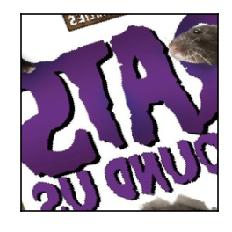

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(24):
    ax = fig.add_subplot(2, 24/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:




import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

1. Upload zip file signs.zip to 'My Drive' 
2. Mount your drive using code below. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


 3. Unzip the file:



In [0]:
!unzip signs.zip

You just unziped your folder. Take a look at the structure, and pictures

In [0]:
import os
os.chdir("/content/drive/My Drive/")

Define transforms, rezise, rotate slightly, preform horizontal flip

________________________________